# Weakly supervised learning

Quick implementation of https://arxiv.org/abs/1702.00414

In [1]:
import numpy as np
import keras.backend as K

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, n_features=2, centers=[(0, 0), (0, 2)], random_state=1)
y = y.astype(float)

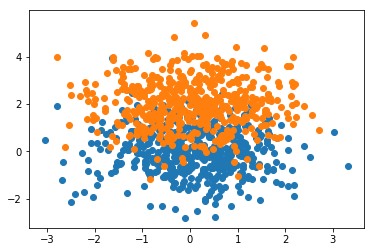

In [3]:
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])

In [4]:
# make 2 batches of data at random
indices = np.random.permutation(len(X))
batch1 = indices[:400]
batch2 = indices[400:]
y_props = np.zeros(len(y))
y_props[batch1] = np.mean(y[batch1])
y_props[batch2] = np.mean(y[batch2])

In [5]:
y_props[:10]

array([ 0.495     ,  0.50333333,  0.50333333,  0.495     ,  0.495     ,
        0.50333333,  0.495     ,  0.50333333,  0.495     ,  0.50333333])

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, y_props_train, y_props_test = train_test_split(X, y, y_props, test_size=0.25)

In [7]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

x = Input(shape=(2,))
h = Dense(20, activation="relu")(x)
h = Dense(20, activation="relu")(h)
h = Dense(1, activation="sigmoid")(h)
net1 = Model(x, h)
net1.compile(loss="binary_crossentropy", optimizer=Adam())

x = Input(shape=(2,))
h = Dense(20, activation="relu")(x)
h = Dense(20, activation="relu")(h)
h = Dense(1, activation="sigmoid")(h)
net2 = Model(x, h)
def loss_function(ytrue, ypred):
    # Assuming that ypred contains the same ratio replicated
    #loss = K.sum(ypred)/ypred.shape[0] - K.sum(ytrue)/ypred.shape[0]   # does not work with tensorflow backend
    den = K.cast(K.shape(ypred)[0], dtype="float32")
    loss = K.sum(ypred) / den - K.sum(ytrue) / den
    #loss = K.mean(ypred) - K.mean(ytrue)  # equivalent to above
    loss = K.square(loss)
    return loss
net2.compile(loss=loss_function, optimizer=Adam())

In [8]:
net1.fit(X_train, y_train, nb_epoch=50, validation_data=(X_test, y_test))

Train on 750 samples, validate on 250 samples
Epoch 1/50
750/750 [==============================] - 0s - loss: 0.8489 - val_loss: 0.6779
Epoch 2/50
750/750 [==============================] - 0s - loss: 0.6047 - val_loss: 0.5532
Epoch 3/50
750/750 [==============================] - 0s - loss: 0.5321 - val_loss: 0.5027
Epoch 4/50
750/750 [==============================] - 0s - loss: 0.4914 - val_loss: 0.4623
Epoch 5/50
750/750 [==============================] - 0s - loss: 0.4579 - val_loss: 0.4282
Epoch 6/50
750/750 [==============================] - 0s - loss: 0.4312 - val_loss: 0.4022
Epoch 7/50
750/750 [==============================] - 0s - loss: 0.4109 - val_loss: 0.3847
Epoch 8/50
750/750 [==============================] - 0s - loss: 0.3974 - val_loss: 0.3741
Epoch 9/50
750/750 [==============================] - 0s - loss: 0.3890 - val_loss: 0.3681
Epoch 10/50
750/750 [==============================] - 0s - loss: 0.3847 - val_loss: 0.3649
Epoch 11/50
750/750 [======================

In [9]:
net2.fit(X_train, y_props_train, nb_epoch=50, validation_data=(X_test, y_props_test))

Train on 750 samples, validate on 250 samples
Epoch 1/50
750/750 [==============================] - 0s - loss: 0.0047 - val_loss: 9.0365e-04
Epoch 2/50
750/750 [==============================] - 0s - loss: 2.5208e-04 - val_loss: 8.0711e-05
Epoch 3/50
750/750 [==============================] - 0s - loss: 8.7062e-05 - val_loss: 6.4790e-05
Epoch 4/50
750/750 [==============================] - 0s - loss: 4.0069e-05 - val_loss: 5.7704e-05
Epoch 5/50
750/750 [==============================] - 0s - loss: 2.1700e-05 - val_loss: 5.1597e-05
Epoch 6/50
750/750 [==============================] - 0s - loss: 3.9205e-05 - val_loss: 4.7038e-05
Epoch 7/50
750/750 [==============================] - 0s - loss: 3.4602e-05 - val_loss: 4.3249e-05
Epoch 8/50
750/750 [==============================] - 0s - loss: 3.9102e-05 - val_loss: 3.8557e-05
Epoch 9/50
750/750 [==============================] - 0s - loss: 2.5519e-05 - val_loss: 3.2773e-05
Epoch 10/50
750/750 [==============================] - 0s - loss: 2

In [10]:
from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_test, net1.predict(X_test)))
print(roc_auc_score(y_test, net2.predict(X_test)))

0.929111168033
0.693839651639


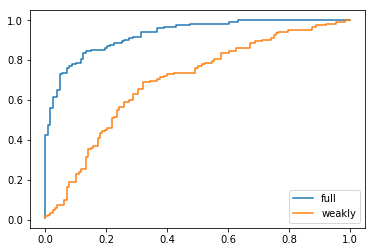

In [11]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, net1.predict(X_test))
plt.plot(fpr, tpr, label="full")
fpr, tpr, _ = roc_curve(y_test, net2.predict(X_test))
plt.plot(fpr, tpr, label="weakly")

plt.legend()
plt.show()